# Text Generation with Recurrent Neural Networks (RNNs)

In this assignment, you'll build upon your understanding of RNNs and Keras to develop a word-level text generation model.  Your goal is to train a model that learns the stylistic nuances of a chosen corpus and generates new, original text segments that echo the source material's essence.

**Datasets**

We've provided several intriguing text corpora to get you started:

*   Mark Twain
*   Charles Dickens
*   William Shakespeare

**Feel free to explore!**  If you have a particular passion for another author, genre, or a specific text, you're encouraged to use your own dataset of raw text.

In [2]:
# Check if we have a GPU available
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU available. If you're on Colab, go to Runtime > Change runtime and select a GPU hardware accelerator.")

Default GPU Device: /device:GPU:0


# 1. Data Preparation (Complete or Incomplete)

Before we can begin training an RNN model, we need to prepare the dataset. This involves cleaning the text, tokenizing words, and creating sequences the model can be trained on.

## 1.1 Data Exploration

Print the first 1000 characters of the dataset. Report the dataset's size and the number of unique characters it contains.

In [4]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to your file in Drive
file_path = '/content/drive/My Drive/mark_twain.txt'

# Load the dataset
def load_dataset(file_path, fraction=0.2):
    with open(file_path, 'r', encoding='utf-8') as f:
        raw_text = f.read()
    return raw_text[:int(fraction * len(raw_text))]

raw_text = load_dataset(file_path)

# Print first 1000 characters
print("First 1000 characters of the dataset:")
print(raw_text[:1000])
# Dataset size (total number of characters)
dataset_size = len(raw_text)
print(f"\nDataset size (total characters): {dataset_size}")

# Number of unique characters in the dataset
unique_characters = set(raw_text)
num_unique_characters = len(unique_characters)
print(f"Number of unique characters: {num_unique_characters}")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
First 1000 characters of the dataset:

The Project Gutenberg EBook of The Prince and The Pauper, Complete by
Mark Twain (Samuel Clemens)

This eBook is for the use of anyone anywhere at no cost and with almost
no restrictions whatsoever. You may copy it, give it away or re-use
it under the terms of the Project Gutenberg License included with this
eBook or online at www.gutenberg.org

Title: The Prince and The Pauper, Complete

Author: Mark Twain (Samuel Clemens)

Release Date: August 20, 2006 [EBook #1837]
Last Updated: February 19, 2018

Language: English

Character set encoding: UTF-8

*** START OF THIS PROJECT GUTENBERG EBOOK PRINCE AND THE PAUPER ***

Produced by David Widger. The earliest PG edition was prepared by Les
Bowler




THE PRINCE AND THE PAUPER

by Mark Twain

The Great Seal

I will set down a tale as it was told to me by one who had it of his

## 1.2 Text Pre-Processing

To prepare the dataset for training, we need to clean the text and create a numerical representation the model can interpret. Perform the following pre-processing steps:

*   Convert the entire text to lowercase.
*   Use the `Tokenizer` class from the `keras.preprocessing.text` module to tokenize the text. You should fit the tokenizer on the text and then convert the text to a sequence of numbers. You can use the `texts_to_sequences` method to do this.

**Note**:
* You'll need to specify an appropriate size for the vocabulary. The number of words in the list of most common words can serve as a guide - does it seem like a reasonable vocabulary size?
* Some of the words will be excluded from the vocabulary, as they don't appear often enough. It's important to provide a value for `oov_token` when creating the Tokenizer instance, so that these words can be represented as "unknown".

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer

text = raw_text.lower()
#Define vocabulary size
VOCAB_SIZE = 5000
oov_token='OOV'
#Create a Tokenizer instance with `OOV_TOKEN`
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
# Fit the tokenizer on the text
tokenizer.fit_on_texts([text])  # Tokenizer expects a list of texts

# Convert text to sequences
sequences = tokenizer.texts_to_sequences([text])[0]  # Flattened sequence

# Optional - View tokenizer details
word_index = tokenizer.word_index
print(f"Vocabulary size (unique tokens): {len(word_index)}")
print(f"Most common words: {list(word_index.items())[:5]}")


Vocabulary size (unique tokens): 21639
Most common words: [('<OOV>', 1), ('the', 2), ('and', 3), ('of', 4), ('a', 5)]


If everything worked, the following line should show you the first 10 words in the vocabulary:

In [6]:
try:
    print(list(tokenizer.word_index.items())[:10])
except AttributeError:
    print("Tokenizer has not been initialized. Possible issue: Complete the relevant section of the assignment to initialize it."
)


[('<OOV>', 1), ('the', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('in', 7), ('it', 8), ('was', 9), ('he', 10)]


## 1.3 Sequence Generation

Now that the text has been tokenized, we need to create sequences the model can be trained on. There are two parts to this:

*   Use the `texts_to_sequences` method from the tokenizer to convert the text to a list of sequences of numbers.
*   Generate the training sequences. Each training sequence should contain `SEQ_LENGTH` token IDs from the text. The target token for each sequence should be the word that follows the sequence in the text.

In [7]:
import numpy as np

SEQ_LENGTH = 5 # Choose an appropriate sequence length

# Generate training sequences
X = []
y = []

for i in range(len(sequences) - SEQ_LENGTH):
    # Input sequence of SEQ_LENGTH tokens
    input_seq = sequences[i:i + SEQ_LENGTH]
    # Target is the next token
    target = sequences[i + SEQ_LENGTH]
    X.append(input_seq)
    y.append(target)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Output the details
print(f"Input sequences (first 5):\n{X[:5]}")
print(f"Targets (first 5): {y[:5]}")

Input sequences (first 5):
[[  2 154 148 908   4]
 [154 148 908   4   2]
 [148 908   4   2 153]
 [908   4   2 153   3]
 [  4   2 153   3   2]]
Targets (first 5): [   2  153    3    2 1176]


Assuming your sequences are stored in `X` and the corresponding targets in `y`, the following line should print the first training sequence and its target:

In [8]:
if len(X) > 0 and len(y) > 0:
    print(f'Sequence: {X[0]}\nTarget: {y[0]}')
    print(f'Translated back to words: {[tokenizer.index_word[i] for i in X[0]]} -> {tokenizer.index_word[y[0]]}')
else:
    print("Training sequences have not been generated. Possible issue: Complete the relevant section of the assignment to initialize it.")


Sequence: [  2 154 148 908   4]
Target: 2
Translated back to words: ['the', 'project', 'gutenberg', 'ebook', 'of'] -> the


And the following code will transform y into a one-hot encoded matrix, and split everything into training and validation sets:

In [9]:
from sklearn.model_selection import train_test_split
import numpy as np

# Ensure that tokenizer has been initialized
if tokenizer is not None:
    # Convert X and y to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Sample 20% of the data
    sample_size = int(0.2 * len(X))  # Calculate 20% of the dataset
    indices = np.random.choice(len(X), size=sample_size, replace=False)  # Randomly select indices
    X = X[indices]
    y = y[indices]

    # Remove sequences with the OOV token (if applicable)
    if "<OOV>" in tokenizer.word_index:  # Adjust based on your OOV token name
        oov_token_index = tokenizer.word_index["<OOV>"]
        mask = y != oov_token_index
        X = X[mask]
        y = y[mask]

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f'X_train shape: {X_train.shape}')
    print(f'y_train shape: {y_train.shape}')
else:
    print("Tokenizer has not been initialized. Please initialize it and load the vocabulary before continuing.")



X_train shape: (68163, 5)
y_train shape: (68163,)


# 2. Model Development (Complete or Incomplete)

With the dataset prepared, it's time to develop the RNN model. You'll need to define the architecture of the model, compile it, and prepare it for training.

## 2.1 Model Architecture

Define the architecture of your RNN model. You can design it however you like, but there are a few features that it's important to include:

*   An embedding layer that learns a dense representation of the input tokens. You'll need to specify the input dimension (the size of the vocabulary) and the output dimension (the size of the dense representation). Remember, you can look at the documentation [here](https://keras.io/api/layers/core_layers/embedding/).
*   At least one recurrent layer. We have learned how to use LSTM layers in class, but you can use other types of recurrent layers if you prefer. You can find the documentation [here](https://keras.io/api/layers/recurrent_layers/lstm/).
*   A dense layer with a softmax activation function. This layer will output a probability distribution over the vocabulary, so that the model can make predictions about the next token.

In [10]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

# Define constants
VOCAB_SIZE = 21638  # Adjust based on your tokenizer's vocabulary size
EMBEDDING_DIM = 128  # Size of the dense representation for each token
RNN_UNITS = 256  # Number of units in the recurrent layer

# Build the RNN model
model = Sequential([
    # Embedding layer: maps input tokens to dense vectors
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length = SEQ_LENGTH),

    # LSTM layer: processes sequential data
    LSTM(RNN_UNITS, return_sequences=False),

    # Dense layer with softmax activation: outputs probabilities for each token in the vocabulary
    Dense(VOCAB_SIZE, activation='softmax')
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


## 2.2 Model Compilation

Compile the model with an appropriate loss function and optimizer. You might also want to track additional metrics, such as accuracy.

Give a short explanation of your choice of loss function and optimizer:

Loss Function - sparse_categorical_crossentropy:
This loss function is ideal for multi-class classification tasks where each output corresponds to one of the vocabulary tokens.
It works directly with integer-encoded labels (y), eliminating the need to one-hot encode the targets.

Optimizer - adam:
adam is widely used because it combines the benefits of both RMSProp and SGD with momentum.
It adapts the learning rate during training, making it robust and efficient for a variety of tasks, including sequential data.

Metrics - accuracy:
Tracking accuracy provides a straightforward measure of how well the model predicts the correct next token.

In [ ]:
# Compile the model
model.compile(
    optimizer='adam',  # Adaptive Moment Estimation optimizer
    loss='sparse_categorical_crossentropy',  # Suitable for multi-class classification
    metrics=['accuracy']  # Track accuracy during training
)


## 2.3 Model Training

Train the model on the training data you've prepared.

* Train your model for 5 epochs with a batch size of 128. Use the validation data for validation.
* Store the training history in a variable called `history`.

In [ ]:
print(f"Length of text sequences: {len(sequences)}")


Length of text sequences: 465192


In [ ]:
SEQ_LENGTH = 5  # or 3 for very short sequences

input_sequences = []
targets = []

# Generate sequences
for i in range(SEQ_LENGTH, len(sequences)):
    input_sequences.append(sequences[i - SEQ_LENGTH:i])
    targets.append(sequences[i])

X = np.array(input_sequences)
y = np.array(targets)

print(f"Generated {len(X)} sequences.")


history = model.fit(
    X,  # Input sequences
    y,  # Target token IDs (not one-hot encoded)
    epochs=5,  # Number of epochs
    batch_size=128,  # Batch size
    validation_split=0.2,  # Use 20% of the data for validation
    verbose=1  # Print progress during training
)



Generated 465187 sequences.
Epoch 1/5
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step - accuracy: 0.0705 - loss: 7.0813 - val_accuracy: 0.1057 - val_loss: 6.5068
Epoch 2/5
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 79s 18ms/step - accuracy: 0.1279 - loss: 5.8996 - val_accuracy: 0.1188 - val_loss: 6.4367
Epoch 3/5
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 81s 18ms/step - accuracy: 0.1599 - loss: 5.2434 - val_accuracy: 0.1203 - val_loss: 6.5505
Epoch 4/5
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 82s 18ms/step - accuracy: 0.1996 - loss: 4.6491 - val_accuracy: 0.1157 - val_loss: 6.7373
Epoch 5/5
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 82s 18ms/step - accuracy: 0.2551 - loss: 4.1033 - val_accuracy: 0.1118 - val_loss: 6.9529


Plot the training history to visualize the model's learning progress. Your plot should include the training and validation loss.

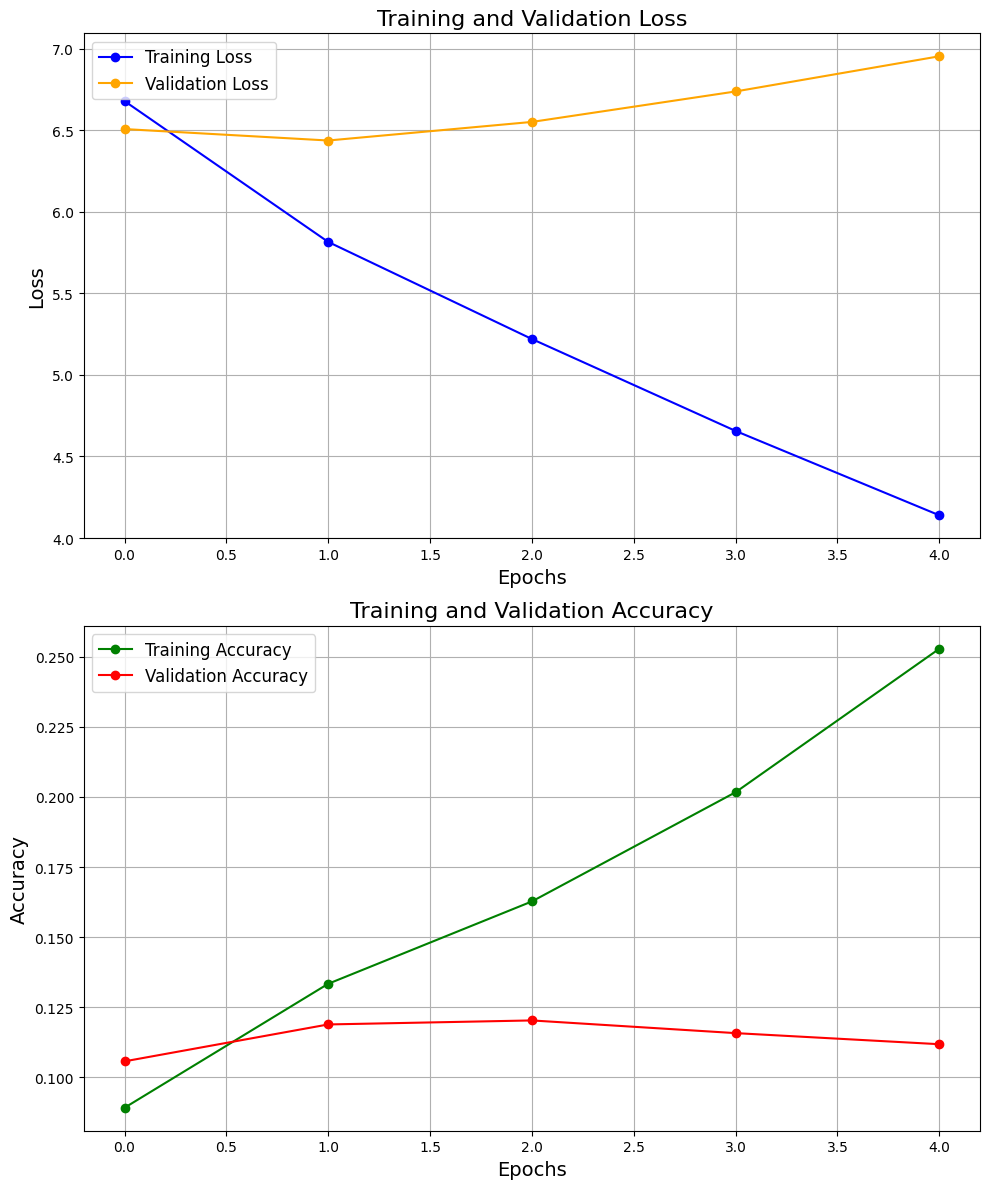

In [ ]:
import matplotlib.pyplot as plt

# Ensure the model's history is available
if 'history' in locals() or 'history' in globals():
    # Extract training and validation loss
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    # Extract training and validation accuracy
    training_accuracy = history.history.get('accuracy')  # Use 'acc' for older Keras versions
    validation_accuracy = history.history.get('val_accuracy')

    # Create subplots for better visualization
    fig, axs = plt.subplots(2, 1, figsize=(10, 12))

    # Plot Loss
    axs[0].plot(training_loss, label='Training Loss', color='blue', marker='o')
    axs[0].plot(validation_loss, label='Validation Loss', color='orange', marker='o')
    axs[0].set_title('Training and Validation Loss', fontsize=16)
    axs[0].set_xlabel('Epochs', fontsize=14)
    axs[0].set_ylabel('Loss', fontsize=14)
    axs[0].legend(fontsize=12)
    axs[0].grid(True)

    # Plot Accuracy
    if training_accuracy and validation_accuracy:
        axs[1].plot(training_accuracy, label='Training Accuracy', color='green', marker='o')
        axs[1].plot(validation_accuracy, label='Validation Accuracy', color='red', marker='o')
        axs[1].set_title('Training and Validation Accuracy', fontsize=16)
        axs[1].set_xlabel('Epochs', fontsize=14)
        axs[1].set_ylabel('Accuracy', fontsize=14)
        axs[1].legend(fontsize=12)
        axs[1].grid(True)
    else:
        axs[1].text(0.5, 0.5, 'Accuracy metrics not found in history.',
                    fontsize=14, ha='center', va='center', color='gray')
        axs[1].axis('off')

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()
else:
    print("Training history not available. Please ensure the model has been trained.")


# 3. Text Generation (Complete or Incomplete)

Write a method called `generate_text` that uses the trained model to generate new text. The method should take the following parameters:

*   `model`: The trained RNN model.
*   `tokenizer`: The tokenizer used to pre-process the text data.
*   `seed_text`: The seed text the model will use to generate new text.
*   `max_sequence_len`: The maximum length of the sequence used to generate new text.

The method should return the generated text.

An overview of the text generation process you should follow:

1. Tokenize the seed text using the tokenizer we built before.
2. Pad the sequences to the same length as the training sequences - you can use the `pad_sequences` method from the `keras.preprocessing.sequence` module, which is documented [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences).
3. Use the model to predict the next token in the sequence. Remember that the model will output a probability distribution over the vocabulary, so you'll need to use `np.argmax` to find the token with the highest probability.
4. Add the predicted token to the sequence and remove the first token.
5. Repeat steps 3-4 until you have generated the desired number of tokens.
6. Convert the generated token IDs back to words and return the combined result as a single string.

This is a challenging task, so don't hesitate to ask for help if you need it. It's okay if the generated text doesn't make much sense yet - we'll work on improving the model next.
As a bonus, you can make your method generate "gpt-style" by having it print out each word as it's generated, so you can see the text being generated in real time.

In [18]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def generate_text(model, tokenizer, seed_text, max_sequence_len):
    sequence = tokenizer.texts_to_sequences([seed_text])[0]
    for _ in range(max_sequence_len):
        sequence = pad_sequences([sequence], maxlen=SEQ_LENGTH, truncating="pre")
        predicted_idx = np.argmax(model.predict(sequence, verbose=0), axis=-1)[0]
        sequence = np.append(sequence[0][1:], predicted_idx)
    generated_text = " ".join(tokenizer.index_word[idx] for idx in sequence if idx != 0)
    return generated_text

# Generate a sample text
seed_text = "home"
print(f"Generated text: {generate_text(model, tokenizer, seed_text, 50)}")


Generated text: deserving hobbled hobbled patches rioter


In [19]:
def get_predicted_word(model, sequence, temperature=0.7):

    # Use the model to predict the next token in the sequence
    yhat = model.predict(sequence, verbose=0).ravel()

    # Apply temperature scaling
    yhat = np.log(yhat + 1e-10) / temperature
    yhat = np.exp(yhat) / np.sum(np.exp(yhat))

    # Get the index of the predicted word based on probabilities
    predicted_idx = np.random.choice(range(len(yhat)), p=yhat)

    return predicted_idx

def generate_text(model, tokenizer, seed_text, max_sequence_len, temperature=1.0):

    sequence = tokenizer.texts_to_sequences([seed_text])[0]
    generated_sequence = sequence[:]

    for _ in range(max_sequence_len):
        # Pad the sequence
        padded_sequence = pad_sequences([sequence], maxlen=max_sequence_len, truncating="pre")

        # Predict the next token using temperature sampling
        predicted_idx = get_predicted_word(model, padded_sequence, temperature=temperature)

        # Stop if a special token or invalid word is predicted
        if predicted_idx == 0 or tokenizer.index_word.get(predicted_idx) is None:
            break

        # Update the sequence
        sequence = np.append(sequence[1:], predicted_idx)
        generated_sequence.append(predicted_idx)

    # Convert token indices back to words
    generated_text = " ".join(tokenizer.index_word[idx] for idx in generated_sequence if idx != 0)
    return generated_text


# Generate a sample text
seed_text = "adventure"
generated_text = generate_text(model, tokenizer, seed_text, 50, temperature=1.0)
print(f"Generated text: {generated_text}")



Generated text: adventure heyday “bring callers gracefully hued strongest lo shipped admiral leaned   opening frame injuriously suspender thronged breedeth link64 sung ’ scatter wistfully 137 'mark amazing ’took teens given bleatings matronly causeway anguished “they nephews dar naples 37 windy remarkably attentions roos' better nicely gives perform candles misgivings survivors condemned loudest complacent


In [20]:
# Test the text generation function
generate_text(model, tokenizer, 'bless', SEQ_LENGTH)

'bless mawning despondency “to annex allowances'

It's likely that the text generated by your model doesn't make much sense yet. This is because the model hasn't been trained for very long, and the training dataset is relatively small.

# 4. Model Refinement (Complete or Incomplete)

In this last section, you'll work on improving your model. There are many ways to do this, but here are a few ideas to get you started:

* Use pre-trained embeddings: the code below will help you to load pre-trained embeddings through Keras.
* Experiment with different model architectures, including the number of layers, the number of units in each layer, and the use of dropout layers.
* Train your model for longer. You can also experiment with different batch sizes.

Implement and test out at least one of these ideas. If you have other ideas for improving the model, feel free to try them out as well.

In [13]:
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip glove.6B.zip

--2024-12-03 20:26:25--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove.6B.zip.1      100%[===================>] 822.24M  5.03MB/s    in 2m 41s  

2024-12-03 20:29:07 (5.11 MB/s) - ‘glove.6B.zip.1’ saved [862182613/862182613]

Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [11]:
import numpy as np
# Load the pre-trained embeddings
embeddings_index = {}
try:
    with open('glove.6B.100d.txt', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f'Found {len(embeddings_index)} word vectors.')
except FileNotFoundError:
    print("'glove.6B.100d.txt' File not found. Please make sure you have ran the previous cell.")

Found 400000 word vectors.


In [12]:
# Check if VOCAB_SIZE is set
VOCAB_SIZE=5000
# Create an embedding matrix
embedding_matrix = np.zeros((VOCAB_SIZE, 100))
for word, i in tokenizer.word_index.items():
    if i < VOCAB_SIZE:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
              embedding_matrix[i] = embedding_vector

In [13]:
# Check if VOCAB_SIZE is set
if VOCAB_SIZE is None:
    print("You need to complete the previous parts of your assignment in order for this to work.")
else:
    embedding_layer = Embedding(
        VOCAB_SIZE, 100, weights=[embedding_matrix], trainable=False
    )

In [23]:
# Define a new model and train it

# Define the model
model2 = Sequential()

# Add the embedding layer with pre-trained embeddings
model2.add(embedding_layer)

# Add LSTM layers
model2.add(LSTM(128, return_sequences=True))
model2.add(LSTM(128))

# Add a dense output layer
model2.add(Dense(VOCAB_SIZE, activation='softmax'))

# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(model2.summary())


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │         500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 500,000 (1.91 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 500,000 (1.91 MB)

None


In [24]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=VOCAB_SIZE)
y_val = to_categorical(y_val, num_classes=VOCAB_SIZE)

print(f"y_train shape after encoding: {y_train.shape}")
print(f"y_val shape after encoding: {y_val.shape}")


# Train the model
history = model2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,  # Adjust the number of epochs based on performance
    batch_size=128,  # Experiment with batch sizes
    verbose=1
)



y_train shape after encoding: (68210, 5000)
y_val shape after encoding: (17053, 5000)
Epoch 1/20
533/533 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.0615 - loss: 6.7938 - val_accuracy: 0.0776 - val_loss: 6.3178
Epoch 2/20
533/533 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.0747 - loss: 6.2462 - val_accuracy: 0.0844 - val_loss: 6.1580
Epoch 3/20
533/533 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.0843 - loss: 6.0383 - val_accuracy: 0.0941 - val_loss: 6.0355
Epoch 4/20
533/533 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.0932 - loss: 5.8936 - val_accuracy: 0.0933 - val_loss: 5.9631
Epoch 5/20
533/533 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.0969 - loss: 5.7748 - val_accuracy: 0.1001 - val_loss: 5.9020
Epoch 6/20
533/533 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.1018 - loss: 5.6755 - val_accuracy: 0.1081 - val_loss: 5.8554
Epoch 7/20
533/533 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.1098 - loss: 5.5497 - val_accuracy: 0.1108 - val_loss: 5.8266
Epoch 8/20
5

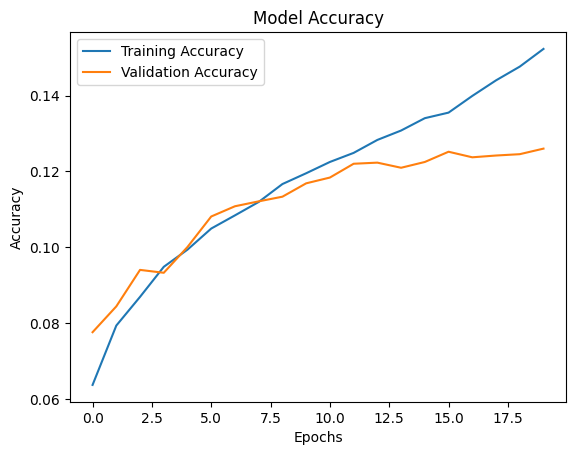

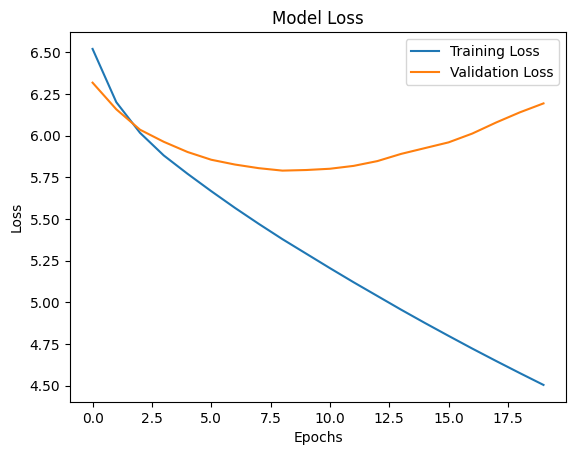

In [25]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [14]:
#adding dropout to reduce overfitting
from tensorflow.keras.layers import Dropout

# Define a new model and train it

# Define the model
model3 = Sequential()

# Add the embedding layer with pre-trained embeddings
model3.add(embedding_layer)

# Add LSTM layers
model3.add(LSTM(128, return_sequences=True))
model3.add(Dropout(0.2))
model3.add(LSTM(128))
model3.add(Dropout(0.2))


# Add a dense output layer
model3.add(Dense(VOCAB_SIZE, activation='softmax'))

# Compile the model
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(model3.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │         500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 500,000 (1.91 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 500,000 (1.91 MB)

None


In [15]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=VOCAB_SIZE)
y_val = to_categorical(y_val, num_classes=VOCAB_SIZE)

print(f"y_train shape after encoding: {y_train.shape}")
print(f"y_val shape after encoding: {y_val.shape}")


# Train the model
history = model3.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,  # Adjust the number of epochs based on performance
    batch_size=128,  # Experiment with batch sizes
    verbose=1
)

y_train shape after encoding: (68163, 5000)
y_val shape after encoding: (17041, 5000)
Epoch 1/20
533/533 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.0558 - loss: 6.8020 - val_accuracy: 0.0604 - val_loss: 6.3458
Epoch 2/20
533/533 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.0727 - loss: 6.2585 - val_accuracy: 0.0802 - val_loss: 6.2429
Epoch 3/20
533/533 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.0832 - loss: 6.1227 - val_accuracy: 0.0880 - val_loss: 6.1086
Epoch 4/20
533/533 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.0922 - loss: 5.9644 - val_accuracy: 0.0959 - val_loss: 6.0200
Epoch 5/20
533/533 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.0930 - loss: 5.8611 - val_accuracy: 0.1022 - val_loss: 5.9608
Epoch 6/20
533/533 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.0998 - loss: 5.7359 - val_accuracy: 0.1072 - val_loss: 5.9130
Epoch 7/20
533/533 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.1041 - loss: 5.6571 - val_accuracy: 0.1097 - val_loss: 5.8677
Epoch 8/

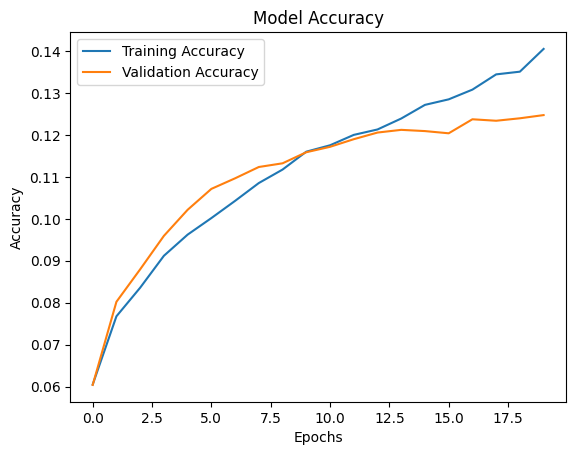

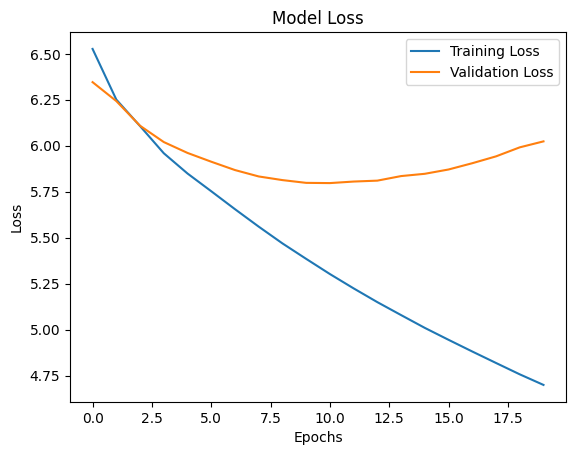

In [16]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Adding dropout slightly increased validation set accuracy and slightly reduced overfitting. The main issue with the model is validation loss increasing after epoch 9, which is likely related to a small vocabulary size of 5000. Vocabulary was selected due to RAM limitations and the kernel crashing with larger vocabulary sizes.

Alternative Explanations for Increasing Validation Loss:
Overfitting: If the model fits too closely to the training data, it may fail to generalize well to the validation set. Adding dropout, as you've done, is a good strategy to counteract this.

Data Imbalance: If your training data distribution does not represent the validation data well, the model could struggle on validation samples.
Insufficient Training Data: If the dataset is small relative to the task complexity, the model might not have learned enough to generalize effectively.

Learning Rate and Training Duration: An improper learning rate or overtraining can lead to validation loss divergence. Consider reducing the learning rate as training progresses or employing early stopping.

Actions that can be taken to further reduce overfitting and improve accuracy:
1. Increase vocabulary size with more ram.
2. Use subword tokenization methods like Byte Pair Encoding (BPE) or WordPiece, which effectively reduce the vocabulary size by breaking rare words into smaller units.
3. Use Dynamic Sampling: Process text data in smaller batches or chunks, reducing the memory overhead at any given time.
4. Use Trainable Embeddings with Lower Dimensions: Experiment with trainable embeddings using smaller dimensional vectors (e.g., 50D instead of 100D) to save memory.
5. Verify Vocabulary Appropriateness: Test with slightly larger vocabulary sizes if feasible, or use subword tokenization methods like Byte Pair Encoding (BPE).
6. Analyze Validation Data: Ensure your validation data is representative of the training data.
7. Tune Training Hyperparameters: Experiment with lower learning rates, more regularization, or training for fewer epochs.
8. Revisit Model Capacity: Check if the model size is appropriate for the task. A too-large model might overfit even with regularization.

## Criteria

|Criteria|Complete|Incomplete|
|----|----|----|
|Task 1|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 2|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 3|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 4|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|

## Submission Information

🚨**Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)**🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.